# Q-learning

## Dependencies

In [1]:
# Author: Andrea Pierré
# License: GPLv3+

from typing import NamedTuple
from enum import Enum

import numpy as np
from numpy.random import default_rng
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
%load_ext lab_black

## Parameters

In [4]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    seed: int  # Define a seed so that we get reproducible results
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    epsilon: float  # Exploration probability

In [5]:
params = Params(
    total_episodes=50,
    learning_rate=0.3,
    gamma=0.95,
    seed=42,
    n_runs=100,
    action_size=None,
    state_size=None,
    epsilon=0.1,
)
params

Params(total_episodes=50, learning_rate=0.3, gamma=0.95, seed=42, n_runs=100, action_size=None, state_size=None, epsilon=0.1)

In [6]:
# Set the seed
rng = np.random.default_rng(params.seed)

## The environment

In [7]:
class Actions(Enum):
    Left = 0
    Right = 1

In [8]:
class RandomWalk1D:
    """`RandomWalk1D` to test the Q-learning algorithm.

    The agent (A) starts in state 3.
    The actions it can take are going left or right.
    The episode ends when it reaches state 0 or 6.
    When it reaches state 0, it gets a reward of -1,
    when it reaches state 6, it gets a reward of +1.
    At any other state it gets a reward of zero.

    Rewards:  -1   <-A->  +1
    States:  <-0-1-2-3-4-5-6->

    Environment inspired from `ReinforcementLearning.jl`'s tutorial:
    https://juliareinforcementlearning.org/docs/tutorial/
    """

    def __init__(self):
        self.observation_space = np.arange(0, 7)
        self.action_space = [item.value for item in list(Actions)]
        self.right_boundary = 6
        self.left_boundary = 0
        self.reset()

    def reset(self):
        self.current_state = 3
        return self.current_state

    def step(self, action):
        if action == Actions.Left.value:
            new_state = np.max([self.left_boundary, self.current_state - 1])
        elif action == Actions.Right.value:
            new_state = np.min([self.right_boundary, self.current_state + 1])
        else:
            raise ValueError("Impossible action type")
        self.current_state = new_state
        reward = self.reward(self.current_state)
        is_terminated = self.is_terminated(self.current_state)
        return new_state, reward, is_terminated

    def reward(self, observation):
        reward = 0
        if observation == self.right_boundary:
            reward = 1
        elif observation == self.left_boundary:
            reward = -1
        return reward

    def is_terminated(self, observation):
        is_terminated = False
        if observation == self.right_boundary or observation == self.left_boundary:
            is_terminated = True
        return is_terminated

In [9]:
env = RandomWalk1D()

In [10]:
params = params._replace(action_size=len(env.action_space))
params = params._replace(state_size=len(env.observation_space))
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

Action size: 2
State size: 7


## The learning algorithm: Q-learning

In [11]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))

## The explorer algorithm: RandomPolicy

## The explorer algorithm: $\epsilon$-greedy

In [12]:
class RandomPolicy:
    """The RandomPolicy simply draws a random element from the action set."""

    def __init__(self, rng=None):
        if rng:
            self.rng = rng
        else:
            self.rng = default_rng()

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        action = self.rng.choice(action_space)

        return action

In [13]:
class EpsilonGreedy:
    def __init__(self, epsilon, rng=None):
        self.epsilon = epsilon
        if rng:
            self.rng = rng
        else:
            self.rng = default_rng()

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = self.rng.uniform(0, 1)

        def sample(action_space):
            return self.rng.choice(action_space)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = sample(action_space)

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = sample(action_space)
            else:
                action = np.argmax(qtable[state, :])
        return action

## Running the environment

In [14]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)

In [15]:
# explorer = RandomPolicy(rng=rng)
explorer = EpsilonGreedy(epsilon=params.epsilon, rng=rng)

This will be our main function to run our environment until the maximum
number of episodes `params.total_episodes`.
To account for stochasticity, we will also run our environment a few times.

In [16]:
rewards = np.zeros((params.total_episodes, params.n_runs))
steps = np.zeros((params.total_episodes, params.n_runs))
episodes = np.arange(params.total_episodes)
qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset_qtable()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step = 0
        done = False
        total_rewards = 0

        while not done:
            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            # Log all states and actions
            all_states.append(state)
            all_actions.append(action)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action)

            learner.qtable[state, action] = learner.update(
                state, action, reward, new_state
            )

            total_rewards += reward
            step += 1

            # Our new state is state
            state = new_state

        # Log all rewards and steps
        rewards[episode, run] = total_rewards
        steps[episode, run] = step
    qtables[run, :, :] = learner.qtable

## Visualization

In [17]:
def postprocess(episodes, params, rewards, steps, qtables):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs
    return res, qtable

In [18]:
res, qtable = postprocess(episodes, params, rewards, steps, qtables)

In [19]:
res

,Episodes,Rewards,Steps
0,0,-1.0,29.0
1,1,-1.0,63.0
2,2,1.0,31.0
3,3,-1.0,5.0
4,4,1.0,9.0
...,...,...,...
4995,45,1.0,3.0
4996,46,1.0,5.0
4997,47,1.0,3.0
4998,48,1.0,3.0


In [20]:
qtable

array([[ 0.        ,  0.        ],
       [-0.359919  ,  0.03779104],
       [ 0.0049554 ,  0.41945456],
       [ 0.12436443,  0.90249584],
       [ 0.41791111,  0.94999955],
       [ 0.43606934,  0.99999997],
       [ 0.        ,  0.        ]])

As a sanity check, we will plot the distributions of states and actions
with the following function:

In [21]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

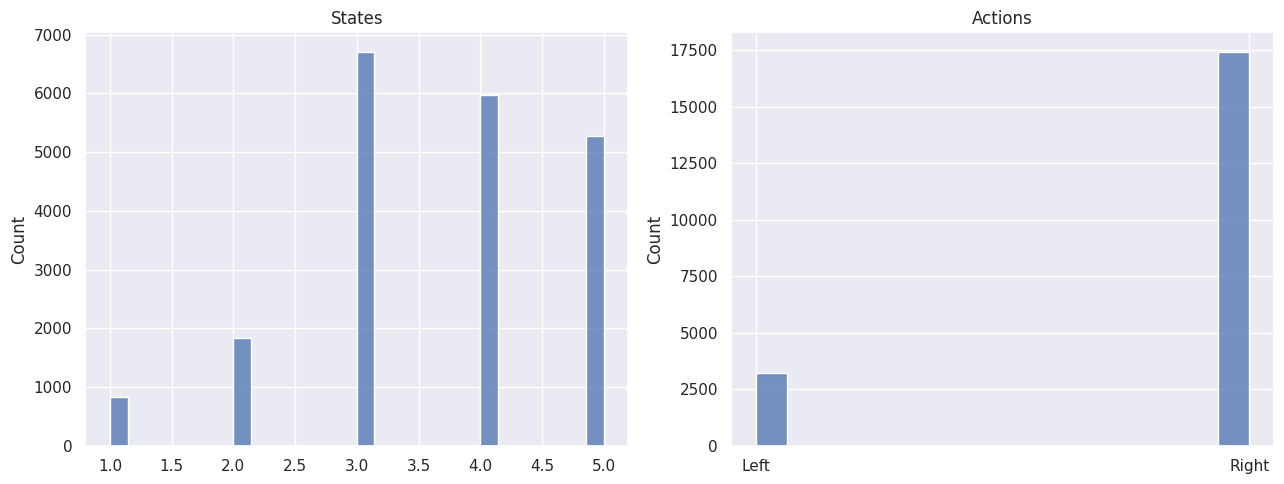

In [22]:
plot_states_actions_distribution(all_states, all_actions)

In [23]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(ylabel=f"Rewards\naveraged over {params.n_runs} runs")

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(ylabel=f"Steps number\naveraged over {params.n_runs} runs")

    fig.tight_layout()
    plt.show()

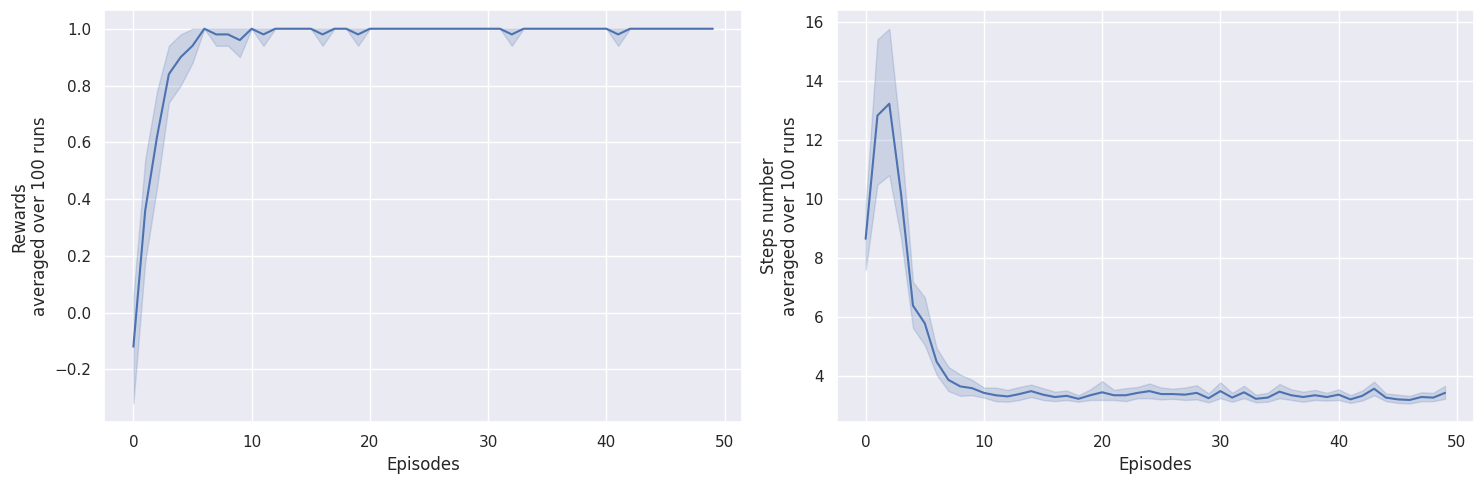

In [24]:
plot_steps_and_rewards(res)

In [25]:
qtable

array([[ 0.        ,  0.        ],
       [-0.359919  ,  0.03779104],
       [ 0.0049554 ,  0.41945456],
       [ 0.12436443,  0.90249584],
       [ 0.41791111,  0.94999955],
       [ 0.43606934,  0.99999997],
       [ 0.        ,  0.        ]])

In [26]:
qtable_flat = qtable.flatten()[np.newaxis, :]
qtable_flat

array([[ 0.        ,  0.        , -0.359919  ,  0.03779104,  0.0049554 ,
         0.41945456,  0.12436443,  0.90249584,  0.41791111,  0.94999955,
         0.43606934,  0.99999997,  0.        ,  0.        ]])

In [27]:
def plot_q_values():
    fig, ax = plt.subplots(figsize=(15, 1.5))
    cmap = sns.color_palette("vlag", as_cmap=True)
    chart = sns.heatmap(
        qtable.flatten()[np.newaxis, :],
        annot=True,
        ax=ax,
        cmap=cmap,
        yticklabels=False,  # linewidth=0.5
        center=0,
    )
    states_nodes = np.arange(1, 14, 2)
    chart.set_xticks(states_nodes)
    chart.set_xticklabels([str(item) for item in np.arange(0, 7, 1)])
    chart.set_title("Q values")
    ax.tick_params(bottom=True)

    # Add actions arrows
    for node in states_nodes:
        arrows_left = {"x_tail": node, "y_tail": 1.3, "x_head": node - 1, "y_head": 1.3}
        arrow = mpatches.FancyArrowPatch(
            (arrows_left["x_tail"], arrows_left["y_tail"]),
            (arrows_left["x_head"], arrows_left["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)
        arrows_right = {
            "x_tail": node,
            "y_tail": 1.3,
            "x_head": node + 1,
            "y_head": 1.3,
        }
        arrow = mpatches.FancyArrowPatch(
            (arrows_right["x_tail"], arrows_right["y_tail"]),
            (arrows_right["x_head"], arrows_right["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)

        # Add rectangle to separate each state pair
        rect = mpatches.Rectangle(
            (node - 1, 0),
            2,
            1,
            linewidth=2,
            edgecolor="k",
            facecolor="none",
            clip_on=False,
        )
        ax.add_patch(rect)

    plt.show()

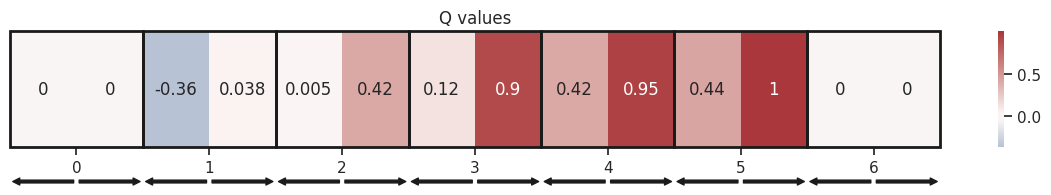

In [28]:
plot_q_values()

## References
- Code inspired from [Deep Reinforcement Learning Course](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/) by [Thomas Simonini](http://simoninithomas.com/)
- Environment inspired from [the `ReinforcementLearning.jl` tutorial](https://juliareinforcementlearning.org/docs/tutorial/)
- [Introduction to Reinforcement Learning](https://gibberblot.github.io/rl-notes/index.html) by Tim Miller (University of Melbourne)